In [1]:
from chiborg import jk_data, jk_hyp, jk_calc, tm_prior
from chiborg.util import get_mut_info
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from more_itertools import powerset

# General object structure of the code

There are three basic objects in the chiborg package: `jk_data`, `jk_hyp`, and `jk_calc`

1. `jk_data`: This object holds the data and covariance information used from which the inference is done. It essentially has two exclusive modes: simulation and measurement. In other words, any given instance of a `jk_data` object will either contain measured data and their covariances, or it will simulate data according to the user's settings.



2. `jk_hyp`: This object holds all of the hypothesis information for the inference. Requires a `jk_data` object for construction.

- For the bias prior, there are two automated modes, `'diagonal'` and `'partition'`, as well as a `'manual'` mode. The meaning of `'diagonal'` and `'partition'` are explained in the paper. When using either of these modes, the user must submit a `bias_mean` vector, which is propagated appropriately to all the different hypotheses accordingly, as well as a `bias_cov` vector, which just holds variance information for the bias prior (the off-diagonal terms are either 0 for `'diagonal'` or fully correlated for `'partition'`). When using the `'manual'` mode, the user must supply their `bias_mean` vectors and `bias_cov` _matrices_. There must be one such vector and matrix for each hypothesis. 



- The prior for the true mean is set using a special namedtuple object called `tm_prior`. This has three basic attributes: a `func` (a callable that evaluates the pdf of the prior), `bounds` (a two-element list containing the bounds of the prior support), `params` (a dictionary that contains keyword arguments for the callable in `func`), and a `name`, which must be 'gaussian' if using a Gaussian prior and desiring Analytic calculation of the posteriors. The default settings for this are a Gaussian prior (`func` is `scipy.stats.norm.pdf`), which is required for the fully analytic calculation. If using the numerical marginalization approach, this is flexible.


- The prior for the hypotheses (`hyp_prior` keyword) is just a 1-d discrete prior. Default is `None`, which is a flat prior. The paper has details on why one might not want a flat prior. In that case, must supply one probability for each hypothesis, and probabilities should sum to 1.

3. `jk_calc`: Holds all the calculation methods for the marginalization, etc. Must supply with a `jk_hyp` object. Only other choice is whether to do the final marginalization (over the true mean prior) analytically or not.


# General operational flow

1. Construct a `jk_data` object, either using simulated data (useful for understanding false positive rates and information-theoretic quantities), or using measured data.


2. Construct a `jk_hyp` object from this `jk_data` object, adjusting the parameters according to the desired analysis.


3. Feed this `jk_hyp` object (and implicitly the `jk_data` object) to a `jk_calc` object to calculate the likelihoods, posteriors, etc.

# Notebook structure

First we reproduce a result from the paper using a small simulated data set, which shows the basic pipeline. We then show some basic examples using large simulated data sets that should hopefully inspire confidence e.g. checking that numerical and analytic marginalization over the true mean are the same to machine precision, and checking that a highly nongaussian prior can be used. We then show how to play around with some of the information theoretic concepts like _mutual information_. Finally, we show how to use a `'manual'` hypothesis set.

#### <span style="color:blue">*Readers are strongly encouraged to read the comments in the code of this notebook.*</span> 

## Analyzing a small set of independent measurements

In this section we just run through the basic API when applying the jackknife test to some measured data.

### Set up the jk_data object with our "measurements"

Use np.random.normal to make some fake data to pass to the jackknife test. We could use the simulation pipeline in jk_data to make this set, but the purpose of this example is to see how the API works with measured data.

In [2]:
np.random.seed(47)
bias_strength = 4
true_mean = 0.05
noise_width = 1
num_dat = 3

# Make a data set where the last datum is biased
fake_meas = np.random.normal(loc=true_mean, scale=noise_width, size=3) + np.array([0, 0, bias_strength])
fake_noise_cov = np.diag(np.full(3, noise_width)) # Pretend we know the error bars exactly

jkd = jk_data(meas_dat=fake_meas, noise_cov=fake_noise_cov, simulate=False, num_draw=1, num_dat=num_dat)





### Set up  the jk_hyp object

In [3]:
# Pretend we know the bias very well, but not which datum it might appear in
bias_mean = np.full(num_dat, bias_strength) 
bias_cov = np.full(num_dat, 1e-2) # Using the diagonal hypothesis set, so just need a vector
# Pretend we sort of know where our data should land, but experiments have improved on our past beliefs
tmp = tm_prior(func=norm.pdf,
               bounds=[-np.inf, np.inf],
               params={"loc": 4 * true_mean, "scale": 2 * noise_width},
               name="Gaussian") 
jkh = jk_hyp(jkd,
             bias_mean=bias_mean,
             bias_cov=bias_cov,
             tmp=tmp,
             hyp_prior=None,
             mode="diagonal") # Will make a flat prior for hyp_prior
print(f"Full diagonal set of bias prior means: \n{jkh.bias_prior.mean}")
print(f"Full diagonal set of bias prior covariances: \n{jkh.bias_prior.cov}")

Full diagonal set of bias prior means: 
[[0. 0. 0.]
 [4. 0. 0.]
 [0. 4. 0.]
 [0. 0. 4.]
 [4. 4. 0.]
 [4. 0. 4.]
 [0. 4. 4.]
 [4. 4. 4.]]
Full diagonal set of bias prior covariances: 
[[[0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]]

 [[0.01 0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.  ]]

 [[0.   0.   0.  ]
  [0.   0.01 0.  ]
  [0.   0.   0.  ]]

 [[0.   0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.01]]

 [[0.01 0.   0.  ]
  [0.   0.01 0.  ]
  [0.   0.   0.  ]]

 [[0.01 0.   0.  ]
  [0.   0.   0.  ]
  [0.   0.   0.01]]

 [[0.   0.   0.  ]
  [0.   0.01 0.  ]
  [0.   0.   0.01]]

 [[0.01 0.   0.  ]
  [0.   0.01 0.  ]
  [0.   0.   0.01]]]


### Get the posteriors

Print them out, show that it incriminates the correct configuration (datum with index 2). Essentially the plot is a probability mass plot showing that almost all the mass is contained in the correct bias configuration.

Fully analytic posterior: 
[[4.95652526e-04]
 [9.51866541e-11]
 [4.79976592e-07]
 [8.83540678e-01]
 [1.16050573e-11]
 [2.23186474e-05]
 [1.15556468e-01]
 [3.84402558e-04]]
Bias mean of maximum a posteriori hypothesis: [0. 0. 4.]
Difference between fully analytic and semi-analytic posteriors:
[[-4.77048956e-18]
 [-3.55429169e-24]
 [ 1.16467030e-21]
 [ 1.11022302e-16]
 [ 1.06628751e-25]
 [-1.28749008e-19]
 [-1.38777878e-16]
 [-2.33103467e-18]]


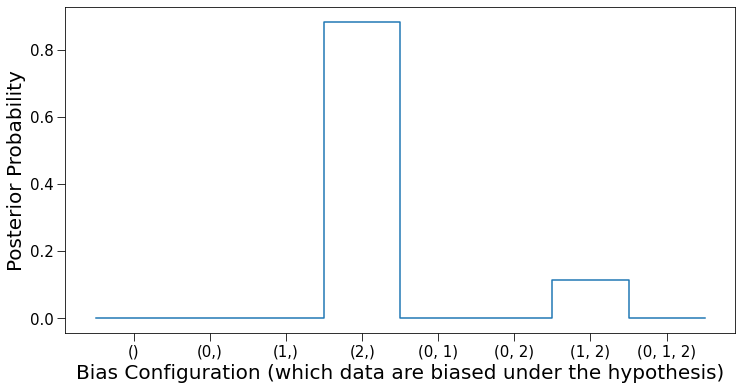

In [4]:
jkc = jk_calc(jkh, analytic=True)
print(f"Fully analytic posterior: \n{jkc.post}") # This should be pretty incriminating
print(f"Bias mean of maximum a posteriori hypothesis: {jkh.bias_prior.mean[np.argmax(jkc.post)]}")

jkc_num = jk_calc(jkh, analytic=False) # Get difference betwen numerical and fully analytic result. They are tiny.
print(f"Difference between fully analytic and semi-analytic posteriors:\n{jkc.post - jkc_num.post}")

# Make a plot of the posteriors for each bias configuration
fontsize=20
tickfontsize=15
ticksize=8
plt.figure(figsize=(12, 6))
post_plot = np.append(jkc.post, 0) # Just telling matplotlib to actually plot the right thing >.<
plt.step(np.arange(-0.5, 8.5), post_plot, where='post') 
plt.xlabel("Bias Configuration (which data are biased under the hypothesis)", fontsize=fontsize)
plt.ylabel("Posterior Probability", fontsize=fontsize)
plt.xticks(np.arange(8), labels=list(powerset(np.arange(3))))
plt.tick_params(labelsize=tickfontsize, size=ticksize)

## Working with large simulations

In this section, we simulate many realizations of toy data sets in order to show how to analyze statistics jackknife test for different hypothesis sets 

Begin by making many realizations of a $N = 2$ data set where one datum is unbiased (true mean = 1) and the other is biased by a value of 5. Set error bars equal to 1 and 2. Make a histogram and print sample covariance.

Sample covariance of data is 
 [[ 4.00716934e+00 -9.57176728e-04]
 [-9.57176728e-04  9.99178319e-01]]


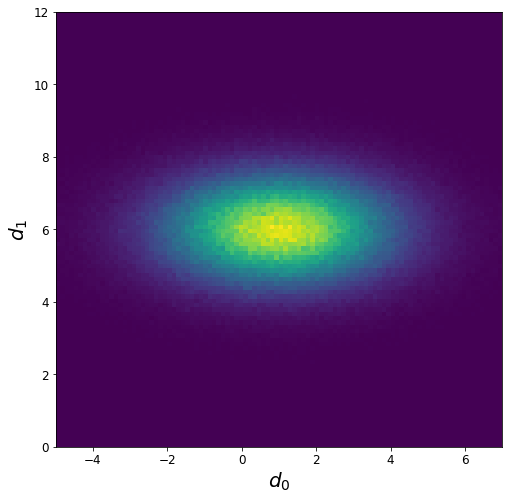

In [5]:

num_draw = int(1e6)

jkd = jk_data(sim_mean=np.ones(2), noise_cov=np.diag([4, 1]), sim_bias=np.array([0, 5]), num_dat=2,
              num_draw=num_draw, simulate=True)

def dat_hist_2d(jkd, xbins=np.linspace(-5,7,101), ybins=np.linspace(0, 12, num=101)):

    plt.figure(figsize=(8, 8))

    _, _, _, _ = plt.hist2d(*jkd.data_draws.T, bins=[xbins, ybins])
    plt.xlabel("$d_0$", fontsize=20)
    plt.ylabel("$d_1$", fontsize=20)
    plt.tick_params(labelsize=12)


dat_hist_2d(jkd)
print(f"Sample covariance of data is \n {np.cov(jkd.data_draws.T)}")

Make a similar data set, but make the bias for the second data point a random gaussian draw, simulating the marginal distribution over a bias prior corresponding to the gaussian draws. This will slightly broaden the biased dimension compared to the previous example ($d_1$).

Sample covariance of data is 
 [[4.00566404e+00 3.39810200e-03]
 [3.39810200e-03 1.99998242e+00]]


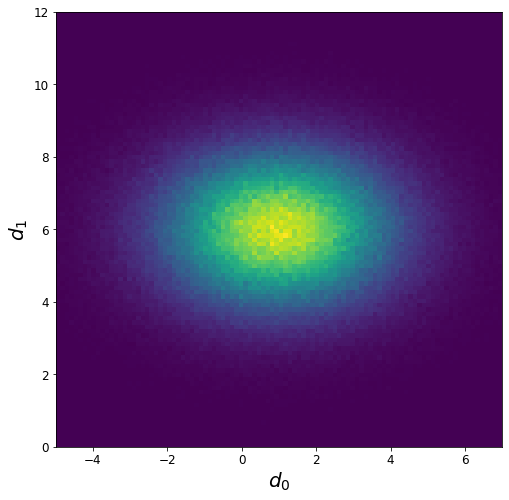

In [6]:
gauss_bias = np.random.multivariate_normal(mean=[0, 5], cov=[[0,0],[0, 1]], size=num_draw)
jkd = jk_data(sim_mean=np.ones(2), noise_cov=np.diag([4,1]), sim_bias=gauss_bias, num_dat=2, num_draw=num_draw,
              simulate=True)

dat_hist_2d(jkd)
print(f"Sample covariance of data is \n {np.cov(jkd.data_draws.T)}")

Put all these realizations through the "diagonal hypothesis" set and analyze the performance. This begins by making a "jk_hyp" object, which contains all the information about the hypothesis sets, such as the prior parameters, number of hypotheses, etc. We then hand it to a "jk_calc" object to do all the probability calculations. We will look for $5\sigma$ biases.

In [7]:
tmp = tm_prior(norm.pdf, [-np.inf, np.inf], {'loc': 1, 'scale': 1e-2}, name="Gaussian")
jkh = jk_hyp(jkd, 5 * np.array([2, 1]), np.ones(2), tmp=tmp)
print(jkh.bias_prior.mean)
print(jkh.bias_prior.cov)

[[ 0.  0.]
 [10.  0.]
 [ 0.  5.]
 [10.  5.]]
[[[0. 0.]
  [0. 0.]]

 [[1. 0.]
  [0. 0.]]

 [[0. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


This is a strong bias compared to the error bar $(5\sigma)$ on the dimension it exists in, so it should be extremely identifiable on average. Make a histogram of each proposed hypothesis according to the MAP rule. Results indicate a correct identification of the bias configuration about 96.9% of the time. There is mild bias misclassification about 1% of the time, and a false negative rate of about 2.2%.

[2.23820e-02 1.70000e-04 9.69066e-01 8.38200e-03]


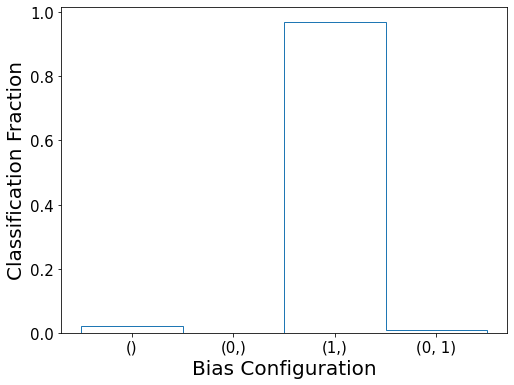

In [8]:
jkc = jk_calc(jkh)
MAP = np.argmax(jkc.post, axis=0) # axis 0 is the "hypothesis" axis

plt.figure(figsize=(8,6))
counts, _, _ = plt.hist(MAP, bins=np.arange(5), histtype="step", density=True)
print(counts)
xticks = np.arange(0.5, 4.5)
xticklabels = [item for item in powerset((0, 1))]
_, _ = plt.xticks(xticks, labels=xticklabels)
_ = plt.xlabel("Bias Configuration", fontsize=20)
_ = plt.ylabel("Classification Fraction", fontsize=20)
plt.tick_params(labelsize=15)

As a consistency check, see if the semi-analytic and fully analytic results agree to within numerical precision. The sharply peaked histogram indicates they do.

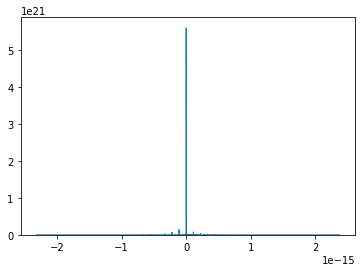

In [9]:
jkc_num = jk_calc(jkh, analytic=False)
_, _, _ = plt.hist((jkc.post - jkc_num.post).flatten(), bins="auto", histtype="step", density=True)

Integrate numerically over a nongaussian, bimodal, generally awkward prior

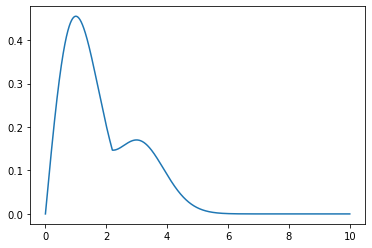

In [10]:
from scipy.stats import rayleigh

def nongauss(x, shift=2.2, mix=0.75, scale=1):
    """
    Superimpose a couple of shifted Rayleigh distributions to make something bimodal
    """
    fval = (mix * rayleigh.pdf(x, scale=scale) + (1 - mix) * rayleigh.pdf(x, loc=shift, scale=scale)) 
    return(fval)

x = np.linspace(0, 10, num=10000)
plt.plot(x, nongauss(x))

tmp = tm_prior(nongauss, [0, np.inf], {"shift": 2.2, "mix": 0.75, "scale": 1}, name="nongauss")
jkh_nongauss = jk_hyp(jkd, 5 * np.array([2, 1]), np.ones(2), tmp=tmp)
jkc_num = jk_calc(jkh_nongauss, analytic=False)
jkc = jk_calc(jkh, analytic=True)

Clearly still manages to identify the correct bias configuration despite a much broader and nongaussian prior. Histogram of correct hypothesis posterior shown in semilog to see the minute difference in the tails. 

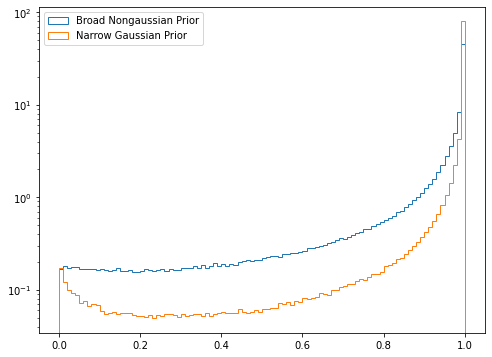

In [11]:

plt.figure(figsize=(8, 6))
_, _, _ = plt.hist(jkc_num.post[2], bins=np.linspace(0, 1, num=101), histtype='step', density=True, log=True,
                   label="Broad Nongaussian Prior")
_, _, _ = plt.hist(jkc.post[2], bins=np.linspace(0, 1, num=101), histtype='step', density=True, log=True,
                   label="Narrow Gaussian Prior")
plt.legend(loc="upper left")

## Exploring 'mutual information'

Here, we use a utility function to calculate the mutual information between the hypotheses and a dataset corresponding to those hypotheses.

In [12]:
get_mut_info(jkc, int(1e4)) # Do a monte carlo estimate of the mutual info for the current jkc using 1e4 draws
# We chose a bias prior distant from the null so it should return something close to 2 in this case

1.9052880424895466

In [13]:
def diag_jkc_setup(bias_mean, bias_cov,
                   sim_mean=0, noise_cov=np.eye(2), sim_bias=np.zeros(2), num_dat=2, num_draw=int(1e4),
                   tmp=tm_prior(norm.pdf, [-np.inf, np.inf], {"loc": 0, "scale": 0}, "gaussian"), hyp_prior=None):
    """
    Set up a jk_calc object using the usual arguments for jk_data, jk_hyp, jk_calc, assuming a simulation, diagonal
    hypothesis set, and fully analytic calculation.
    """
    
    jkd = jk_data(sim_mean=sim_mean, noise_cov=noise_cov, sim_bias=sim_bias, num_dat=num_dat, num_draw=num_draw,
                  simulate=True)
    jkh = jk_hyp(jkd, bias_mean, bias_cov, tmp=tmp, hyp_prior=hyp_prior, mode="diagonal")
    
    jkc = jk_calc(jkh)
    
    return(jkc)

def mut_info_wrapper(bias_means, num_dat=2, num_draw=int(1e4), hyp_prior=None):
    """
    Get the mutual information b/w data and hypotheses for a range of bias prior means.
    """
    Iarr = np.zeros(len(bias_means))
    for bm_ind, bias_mean in enumerate(bias_means):
        bias_mean_use = np.full(num_dat, bias_mean)
        jkc = diag_jkc_setup(bias_mean_use, np.zeros(num_dat), num_dat=num_dat, hyp_prior=hyp_prior)
        Iarr[bm_ind] = get_mut_info(jkc, num_draw)
    return(Iarr)
        
def get_ent(hyp_prior):
    """
    Get the shannon entropy of the hyp_prior, which is the maximum mutual information.
    """
    logs = -np.where(hyp_prior > 0, np.log2(hyp_prior), 0)
    ent = hyp_prior @ logs
    return(ent)

In [14]:
num_dat = 2
hyp_prior = np.full(2**num_dat, 2**(-num_dat))
bias_means = np.logspace(-1, 1.6, num=100)
Iarr = mut_info_wrapper(bias_means, hyp_prior=hyp_prior) # Generate mutual information for the bias prior means above
Imax = get_ent(hyp_prior) # Get the max mutual information obtainable

Mutual information is nearly maximal when bias prior mean is about $5\sigma$ in each biased dimesion (bias prior width is 0), suggesting that when comparing two data points, a tension of $5\sigma$ is decisvely significant if the potential bias is of known strength, while something like $2\sigma$ is insignificant in that it will be difficult to know with certainty whether the two data come from two different distributions biased by $2\sigma$.

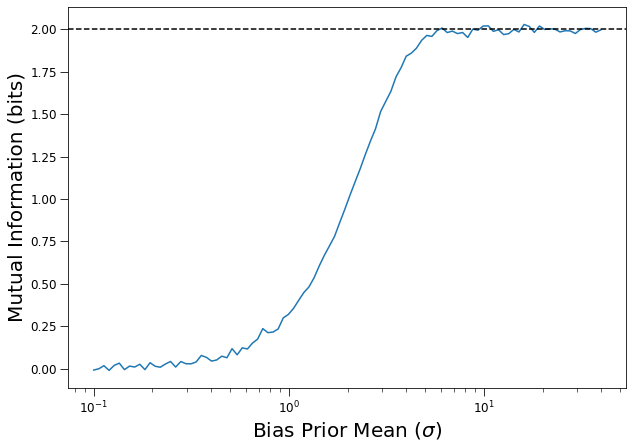

In [15]:
labelsize=20
ticksize=8
tickfont=12
plt.figure(figsize=(10, 7))
plt.plot(bias_means, Iarr)
plt.axhline(Imax, color='black', linestyle='--')
plt.xscale("log")
plt.xlabel("Bias Prior Mean ($\sigma$)", fontsize=labelsize)
plt.ylabel("Mutual Information (bits)", fontsize=labelsize)
plt.tick_params(size=ticksize, labelsize=tickfont)
plt.tick_params(which='minor', size=ticksize / 2, labelsize=tickfont)